# Predict Mobile App Popularity

### FILES
 train.csv- data used for training along with target variable
 
 test.csv- data on which predictions are to be made
 
 sample_submission.csv - sample format of submission

In [1]:
## install needed packages
import sys
! {sys.executable} -m pip install xgboost sklearn

In [2]:
## load needed packages
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost, sklearn
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

In [3]:
%matplotlib inline

In [4]:
## Load train data
train_data = pd.read_csv("train.csv")

In [5]:
## check the data set: type
type(train_data)

pandas.core.frame.DataFrame

In [6]:
## check the data set: cases and features
print("Number of rows:", train_data.shape[0])
print("Number of columns:", train_data.shape[1])

Number of rows: 1975
Number of columns: 10


In [7]:
## check the variable type
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   app_id        1975 non-null   int64 
 1   category      1975 non-null   object
 2   reviews       1975 non-null   int64 
 3   size          1975 non-null   object
 4   installs      1975 non-null   object
 5   price         1975 non-null   object
 6   suitable_for  1975 non-null   object
 7   last_update   1975 non-null   object
 8   latest_ver    1971 non-null   object
 9   popularity    1975 non-null   object
dtypes: int64(2), object(8)
memory usage: 154.4+ KB
None


In [8]:
## Explore the variables 
train_data.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver,popularity
0,330090,PERSONALIZATION,4,511k,50+,0,Everyone,"December 31, 2016",1.4,High
1,226147,GAME,568391,5.2M,"5,000,000+",0,Teen,"July 1, 2014",4.3.1,High
2,107000,FAMILY,144,70M,"1,000+",$2.99,Teen,"January 26, 2018",1.0.0,High
3,217582,FAMILY,1499466,96M,"10,000,000+",0,Teen,"July 24, 2018",1.25.0,High
4,370113,DATING,84,4.5M,"1,000+",0,Mature 17+,"July 6, 2018",8.2,High


In [9]:
## display variable names
# train_data.columns
var_list = list(train_data.columns)
# print(var_list)

In [10]:
## replace missing with "99999"
train_data["latest_ver"].fillna("99999")

0                  1.4
1                4.3.1
2                1.0.0
3               1.25.0
4                  8.2
             ...      
1970            2.21.1
1971    3.3.8.03082017
1972               1.0
1973            1.8.12
1974             1.0.1
Name: latest_ver, Length: 1975, dtype: object

In [11]:
## description: numerical
## only "app_id" and "reviews" are numerical
nvar_list = ['app_id', 'reviews']
# print(nvar_list)

# train_data.describe()

var_des_list = []
for nvar in nvar_list:
    nvar_des = {"Variable": nvar,
                "Median": np.median(train_data[nvar]),
                "Mean": round(np.average(train_data[nvar]), 2),
                "Standard Deviation": round(np.std(train_data[nvar]), 2),
                "Minimum": np.amin(train_data[nvar]),
                "Maximum": np.amax(train_data[nvar]),
                "Range": np.amax(train_data[nvar]) - np.amin(train_data[nvar]), 
                "Kurtosis": round(kurtosis(train_data[nvar]), 2),
                "Skewness": round(skew(train_data[nvar]), 2)
               }
    var_des_list.append(nvar_des)

# print(pd.DataFrame(nvar_des_list))
display(pd.DataFrame(var_des_list))

,Variable,Median,Mean,Standard Deviation,Minimum,Maximum,Range,Kurtosis,Skewness
0,app_id,481867.0,490685.79,288025.99,1160,999218,998058,-1.19,0.03
1,reviews,516.0,198816.16,1493712.36,1,44891723,44891722,476.68,18.91


C:\Users\chena\anaconda3\envs\py37_cpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='app_id'>

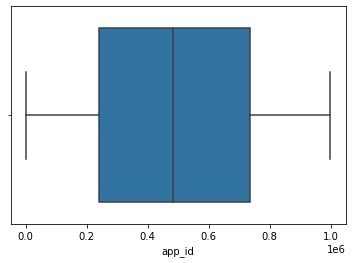

In [12]:
## plot: app_id
sns.boxplot(train_data[nvar_list[0]])
# plt.suptitle('Numerical Data Distribution - Boxplot', fontsize=30)

C:\Users\chena\anaconda3\envs\py37_cpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='reviews'>

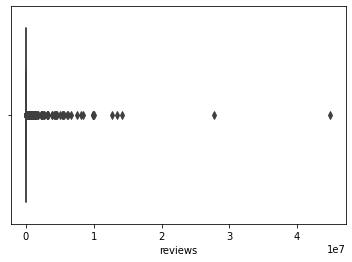

In [13]:
## plot: reviews
sns.boxplot(train_data[nvar_list[1]])
# plt.suptitle('Numerical Data Distribution - Boxplot', fontsize=30)
# fig.subplots_adjust(top=0.95)

In [14]:
## description: categorical 1
## category
unique, counts = np.unique(train_data["category"], return_counts=True)
percentages = counts * 100 / len(train_data["category"])
frequencies = np.asarray((unique, counts, percentages), dtype=object).T
frequencies = pd.DataFrame(data = frequencies, columns = ["category", "Count", "Percentage"])
frequencies_table = frequencies.style.set_caption("App Category").set_table_styles([{
    'selector': 'caption',
    'props': [("text-align", "center"),
              ('color', 'black'),
              ('font-size', '16px'),
              ('font-style','italic'),
              ('font-weight', 'bold')]}])
display(frequencies_table)

,category,Count,Percentage
0,ART_AND_DESIGN,18,0.911392
1,AUTO_AND_VEHICLES,19,0.962025
2,BEAUTY,12,0.607595
3,BOOKS_AND_REFERENCE,57,2.886076
4,BUSINESS,65,3.291139
5,COMICS,19,0.962025
6,COMMUNICATION,35,1.772152
7,DATING,36,1.822785
8,EDUCATION,23,1.164557
9,ENTERTAINMENT,8,0.405063


In [15]:
## description: categorical 2
## size

## split number and the corresponding unit
# size = train_data["size"] 
# print(size[1][-1])
# print(size[1][:-1])

## transform size to numerical values
def transform(row):
    form = row["size"][-1]
    if form == 'k':
        return float(row["size"][:-1])*1000
    elif form == 'M':
        return float(row["size"][:-1])*1000000
    else:
        return float(row["size"])

train_data["size_num"] = train_data.apply(lambda row: transform(row), axis=1)


In [16]:
## description: 
## size_num
var_des_list = []

nvar_des = {"Variable": "size_num",
            "Median": np.median(train_data["size_num"]),
            "Mean": round(np.average(train_data["size_num"]), 2),
            "Standard Deviation": round(np.std(train_data["size_num"]), 2),
            "Minimum": np.amin(train_data["size_num"]),
            "Maximum": np.amax(train_data["size_num"]),
            "Range": np.amax(train_data["size_num"]) - np.amin(train_data["size_num"]), 
            "Kurtosis": round(kurtosis(train_data["size_num"]), 2),
            "Skewness": round(skew(train_data["size_num"]), 2)
           }

var_des_list.append(nvar_des)

# print(pd.DataFrame(nvar_des_list))
display(pd.DataFrame(var_des_list))

,Variable,Median,Mean,Standard Deviation,Minimum,Maximum,Range,Kurtosis,Skewness
0,size_num,12000000.0,20401765.06,21951239.35,29000.0,100000000.0,99971000.0,2.58,1.71


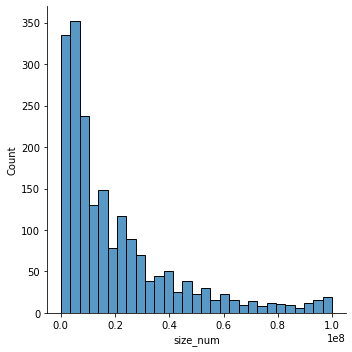

In [17]:
sns.displot(train_data, x="size_num")

In [19]:
## description: categorical 3
## installs
unique, counts = np.unique(train_data["installs"], return_counts=True)
percentages = counts * 100 / len(train_data["installs"])
frequencies = np.asarray((unique, counts, percentages), dtype=object).T
frequencies = pd.DataFrame(data = frequencies, columns = ["installs", "Count", "Percentage"])
frequencies_table = frequencies.style.set_caption("App Installs").set_table_styles([{
    'selector': 'caption',
    'props': [("text-align", "center"),
              ('color', 'black'),
              ('font-size', '16px'),
              ('font-style','italic'),
              ('font-weight', 'bold')]}])
display(frequencies_table)


,installs,Count,Percentage
0,1+,1,0.050633
1,"1,000+",275,13.924051
2,"1,000,000+",258,13.063291
3,"1,000,000,000+",1,0.050633
4,10+,44,2.227848
5,"10,000+",275,13.924051
6,"10,000,000+",137,6.936709
7,100+,143,7.240506
8,"100,000+",237,12.000000
9,"100,000,000+",30,1.518987


In [20]:
## installs --> numerical

## split number and "+"

# form = train_data["installs"] 
# print(form[1][-1])
# fnum = form[1][:-1]
# print(fnum)
# print(int(fnum.replace(',','')))

## remove "+" sign
def transform_install(row):
    fnum = row["installs"][:-1]
    form = int(fnum.replace(',',''))
    return form

train_data["installs_num"] = train_data.apply(lambda row: transform_install(row), axis=1)

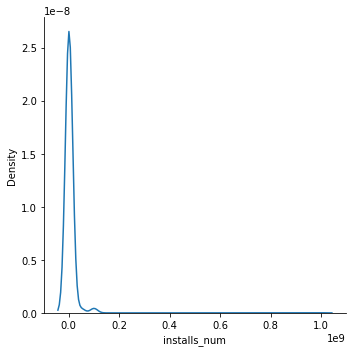

In [21]:
## plotting installs_num
sns.displot(train_data, x="installs_num", kind="kde", bw_adjust=2.5)
# plt.show()

In [23]:
## description: categorical 4
## price
unique, counts = np.unique(train_data["price"], return_counts=True)
percentages = counts * 100 / len(train_data["price"])
frequencies = np.asarray((unique, counts, percentages), dtype=object).T
frequencies = pd.DataFrame(data = frequencies, columns = ["price", "Count", "Percentage"])
frequencies_table = frequencies.style.set_caption("App Price").set_table_styles([{
    'selector': 'caption',
    'props': [("text-align", "center"),
              ('color', 'black'),
              ('font-size', '16px'),
              ('font-style','italic'),
              ('font-weight', 'bold')]}])
display(frequencies_table) 

,price,Count,Percentage
0,$0.99,35,1.772152
1,$1.49,14,0.708861
2,$1.59,1,0.050633
3,$1.75,1,0.050633
4,$1.76,1,0.050633
5,$1.97,1,0.050633
6,$1.99,23,1.164557
7,$10.00,2,0.101266
8,$11.99,1,0.050633
9,$12.99,1,0.050633


In [24]:
## price --> numerical

## split "$" and number 
# form = train_data["price"] 
# print(form)
# print(form[0])
# print(form[0] == "0")
# print(int(form[0]))
# print(form[2])
# print(form[2][0])
# fnum = form[2][1:]
# print(float(fnum.replace(',','')))
# fnum = float(fnum)
# print(fnum)
# type(fnum)

## remove "$" sign

def transform_p(row):
    fnum = row["price"]
    if fnum == "0":
        fnum = int(fnum)
        return fnum
    else: 
        fnum = fnum[1:]
        fnum = float(fnum)
        return fnum

train_data["price_num"] = train_data.apply(lambda row: transform_p(row), axis=1)


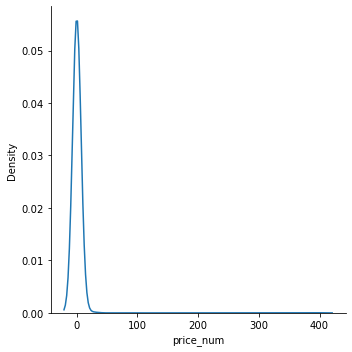

In [25]:
## plotting price_num
# sns.displot(train_data, x="price_num")
sns.displot(train_data, x="price_num", kind="kde", bw_adjust=2.5)

In [26]:
## price --> binary
def transform_bp(row):
    fnum = row["price"]
    if fnum == "0":
        fnum = int(fnum)
        return fnum
    else: 
        return 1

train_data["price_b"] = train_data.apply(lambda row: transform_bp(row), axis=1)

In [27]:
## description: categorical 5
## suitable_for
unique, counts = np.unique(train_data["suitable_for"], return_counts=True)
percentages = counts * 100 / len(train_data["suitable_for"])
frequencies = np.asarray((unique, counts, percentages), dtype=object).T
frequencies = pd.DataFrame(data = frequencies, columns = ["suitable_for", "Count", "Percentage"])
frequencies_table = frequencies.style.set_caption("App Suitable for").set_table_styles([{
    'selector': 'caption',
    'props': [("text-align", "center"),
              ('color', 'black'),
              ('font-size', '16px'),
              ('font-style','italic'),
              ('font-weight', 'bold')]}])
display(frequencies_table)


,suitable_for,Count,Percentage
0,Adults only 18+,1,0.050633
1,Everyone,1641,83.088608
2,Everyone 10+,66,3.341772
3,Mature 17+,79,4.000000
4,Teen,188,9.518987


In [28]:
## description: categorical 6
## last_update

## last_update --> year
# form = train_data["last_update"] 
# print(form[0])
# fnum = form[0][-4:]
# fnum = int(fnum)
# print(fnum)

## keep year

def transform_y(row):
    fnum = row["last_update"][-4:]
    fnum = int(fnum)
    return fnum

train_data["last_update_year"] = train_data.apply(lambda row: transform_y(row), axis=1)

In [29]:
# unique, counts = np.unique(train_data["last_update"], return_counts=True)
# percentages = counts * 100 / len(train_data["last_update"])
# frequencies = np.asarray((unique, counts, percentages), dtype=object).T
# frequencies = pd.DataFrame(data = frequencies, columns = ["last_update", "Count", "Percentage"])
# frequencies_table = frequencies.style.set_caption("App last_update").set_table_styles([{
#     'selector': 'caption',
#     'props': [("text-align", "center"),
#               ('color', 'black'),
#               ('font-size', '16px'),
#               ('font-style','italic'),
#               ('font-weight', 'bold')]}])
# display(frequencies_table)

unique, counts = np.unique(train_data["last_update_year"], return_counts=True)
percentages = counts * 100 / len(train_data["last_update_year"])
frequencies = np.asarray((unique, counts, percentages), dtype=object).T
frequencies = pd.DataFrame(data = frequencies, columns = ["last_update_year", "Count", "Percentage"])
frequencies_table = frequencies.style.set_caption("App last_update_year").set_table_styles([{
    'selector': 'caption',
    'props': [("text-align", "center"),
              ('color', 'black'),
              ('font-size', '16px'),
              ('font-style','italic'),
              ('font-weight', 'bold')]}])
display(frequencies_table)

,last_update_year,Count,Percentage
0,2011,2,0.101266
1,2012,4,0.202532
2,2013,19,0.962025
3,2014,43,2.177215
4,2015,76,3.848101
5,2016,145,7.341772
6,2017,380,19.240506
7,2018,1306,66.126582


In [30]:
## description: categorical 7
## latest_ver

## error with using the previous frequencies_table
## '<' not supported between instances of 'str' and 'float'
# latest_ver = train_data["latest_ver"] 
# print(latest_ver[0])
# fnum = latest_ver[0][:1]
# fnum = str(latest_ver[0])[0] <-- key point: str()
# fnum = int(fnum)
# print(fnum)

## keep the first number 
def transform_ly(row):
    latest_ver = row["latest_ver"] 
    fnum = str(latest_ver)[0]
    return fnum

train_data["latest_ver_h"] = train_data.apply(lambda row: transform_ly(row), axis=1)

In [31]:
unique, counts = np.unique(train_data["latest_ver_h"], return_counts=True)
percentages = counts * 100 / len(train_data["latest_ver_h"])
frequencies = np.asarray((unique, counts, percentages), dtype=object).T
frequencies = pd.DataFrame(data = frequencies, columns = ["latest_ver_h", "Count", "Percentage"])
frequencies_table = frequencies.style.set_caption("App latest_ver_h").set_table_styles([{
    'selector': 'caption',
    'props': [("text-align", "center"),
              ('color', 'black'),
              ('font-size', '16px'),
              ('font-style','italic'),
              ('font-weight', 'bold')]}])
display(frequencies_table)

,latest_ver_h,Count,Percentage
0,0,36,1.822785
1,1,1048,53.063291
2,2,349,17.670886
3,3,202,10.227848
4,4,126,6.379747
5,5,94,4.759494
6,6,47,2.379747
7,7,28,1.417722
8,8,30,1.518987
9,9,11,0.556962


In [32]:
## description: categorical 8
## popularity

unique, counts = np.unique(train_data["popularity"], return_counts=True)
percentages = counts * 100 / len(train_data["popularity"])
frequencies = np.asarray((unique, counts, percentages), dtype=object).T
frequencies = pd.DataFrame(data = frequencies, columns = ["popularity", "Count", "Percentage"])
frequencies_table = frequencies.style.set_caption("App popularity").set_table_styles([{
    'selector': 'caption',
    'props': [("text-align", "center"),
              ('color', 'black'),
              ('font-size', '16px'),
              ('font-style','italic'),
              ('font-weight', 'bold')]}])
display(frequencies_table)

,popularity,Count,Percentage
0,High,1450,73.417722
1,Low,525,26.582278


In [33]:
## recode popularity
train_data["popularity_b"] = train_data["popularity"]
train_data["popularity_b"].replace(['Low','High'], [0,1], inplace=True)

In [34]:
## Re-examine the variables 
## include the recoded
train_data.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver,popularity,size_num,installs_num,price_num,price_b,last_update_year,latest_ver_h,popularity_b
0,330090,PERSONALIZATION,4,511k,50+,0,Everyone,"December 31, 2016",1.4,High,511000.0,50,0.00,0,2016,1,1
1,226147,GAME,568391,5.2M,"5,000,000+",0,Teen,"July 1, 2014",4.3.1,High,5200000.0,5000000,0.00,0,2014,4,1
2,107000,FAMILY,144,70M,"1,000+",$2.99,Teen,"January 26, 2018",1.0.0,High,70000000.0,1000,2.99,1,2018,1,1
3,217582,FAMILY,1499466,96M,"10,000,000+",0,Teen,"July 24, 2018",1.25.0,High,96000000.0,10000000,0.00,0,2018,1,1
4,370113,DATING,84,4.5M,"1,000+",0,Mature 17+,"July 6, 2018",8.2,High,4500000.0,1000,0.00,0,2018,8,1
